C:\Users\joobzm\Desktop\TDK\ACPI\.venv11\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\joobzm\Desktop\TDK\ACPI\.venv11\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


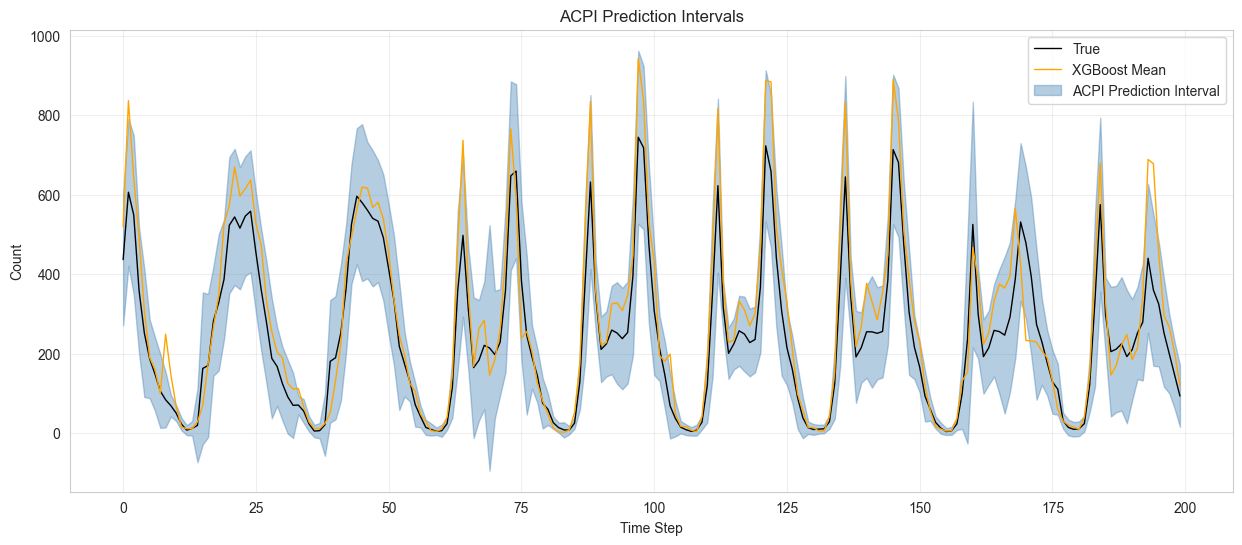

Mean Squared Error: 4562.06
Mean Absolute Error: 44.85
Root Mean Squared Error: 67.54
Mean Absolute Percentage Error: 37.47%
R^2 Score: 0.88
Coverage: 0.94


In [7]:
import numpy as np
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt

from acpi import utils


class XGBoostACPIWrapper:
    """ACPI wrapper for an XGBoost model."""

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Predict using the XGBoost model, handling DMatrix conversion."""
        dmatrix = xgb.DMatrix(X)
        return self.model.predict(dmatrix)


# load the acpi model
acpi_model = joblib.load("./models/acpi_xgboost_model_1.pkl")
DATA_TRAIN_PATH = "../data/train.csv"
DATA_TEST_PATH = "../data/test.csv"
target_col = "count"
context_length = 24
train_df = utils.read_bike_data(DATA_TRAIN_PATH)
test_df = utils.read_bike_data(DATA_TEST_PATH)
feature_cols = [c for c in train_df.columns if c != target_col and c in test_df.columns]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_cols].values.astype(np.float32))
train_target = train_df[target_col].values.astype(np.float32)

# Windowed supervised data
X_all, y_all = utils.build_lag_supervised(train_features, train_target, context_length)

# Time-ordered splits: model train / holdout
train_ratio = 0.8
n_train = int(len(X_all) * train_ratio)
X_test_hold, y_test_hold = X_all[n_train:], y_all[n_train:]

cal_size = 0.5
n_cal = int(len(X_test_hold) * cal_size)
X_test_acpi, y_test_acpi = X_test_hold[n_cal:], y_test_hold[n_cal:]

# Point predictions from the wrapped base model inside ACPI
predictions = acpi_model.model_cali.predict(X_test_acpi)
y_lower, y_upper = acpi_model.predict_pi(X_test_acpi, method='qrf')
utils.plot_acpi_predictions(predictions, y_test_acpi, y_lower, y_upper)
# Evaluate the model
mse = np.mean((predictions - y_test_acpi) ** 2)
mae = np.mean(np.abs(predictions - y_test_acpi))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((predictions - y_test_acpi) / y_test_acpi
                      )) * 100  # Mean Absolute Percentage Error
r2 = 1 - (np.sum((y_test_acpi - predictions) ** 2) / np.sum((y_test_acpi - np.mean(y_test_acpi)) ** 2))
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R^2 Score: {r2:.2f}")
# get coverage
coverage = utils.compute_coverage(y_test_acpi, y_lower, y_upper)
print(f"Coverage: {coverage:.2f}")


# Model based CF generator

In [8]:

class ModelBasedCounterfactualGenerator:
    """
    Model-based counterfactual generator using gradient-free optimization.
    This approach is suitable for black-box models where gradients are not available.
    It finds a single, optimal counterfactual by minimizing input perturbation.
    """

    def __init__(self, prediction_model, proximity_weight=0.1):
        """
        Initializes the generator.

        Args:
            prediction_model: The black-box prediction model with a `predict_pi` method.
            proximity_weight (float): Weight for the L1 distance penalty in the loss function.
        """
        self.prediction_model = prediction_model
        self.proximity_weight = proximity_weight

    def _objective_function(self, x_cf, x_orig, y_true):
        """
        The objective function to minimize. It combines two goals:
        1. Validity Loss: Penalizes the solution if y_true is inside the prediction interval.
        2. Proximity Loss: Penalizes the solution for being far from the original input.
        """
        # Reshape for the prediction model
        x_cf_input = x_cf.reshape(1, -1)

        # 1. Validity Loss
        y_lower_cf, y_upper_cf = self.prediction_model.predict_pi(x_cf_input, method='qrf')

        # Hinge loss: positive penalty only if y_true is inside the interval
        # We want to push y_true outside [y_lower_cf, y_upper_cf]
        validity_loss = np.maximum(0, -(y_true - y_upper_cf[0])) + np.maximum(0, -(y_lower_cf[0] - y_true))

        # 2. Proximity Loss (L1 distance)
        proximity_loss = np.abs(x_cf - x_orig).sum()

        # Total weighted loss
        total_loss = validity_loss + self.proximity_weight * proximity_loss
        return total_loss

    def generate(self, x_orig, y_true, bounds=None, max_iter=10000):
        """
        Generate a single counterfactual explanation.

        Args:
            x_orig (np.ndarray): The original input instance (1D array).
            y_true (float): The true outcome for the original instance.
            bounds (list of tuples, optional): Bounds for each feature, e.g., [(min1, max1), ...].
            max_iter (int): Maximum iterations for the optimizer.

        Returns:
            dict: A dictionary containing the results of the generation process.
        """
        print("Generating counterfactual using model-based optimization...")
        x_orig_np = np.asarray(x_orig, dtype=np.float32).flatten()

        # Define the function to be minimized by scipy's optimizer
        objective = lambda x: self._objective_function(x, x_orig_np, y_true)

        # Use L-BFGS-B optimizer which supports bounds
        result = scipy.optimize.minimize(
            objective,
            x0=x_orig_np,
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': max_iter, 'disp': False}
        )

        x_cf = result.x
        x_cf_input = x_cf.reshape(1, -1)
        y_lower_cf, y_upper_cf = self.prediction_model.predict_pi(x_cf_input, method='qrf')

        # Check if the result is a valid counterfactual
        is_cf = not (y_lower_cf[0] <= y_true <= y_upper_cf[0])

        if not result.success or not is_cf:
            return {"status": "fail_no_counterfactual", "x_cf": x_cf, "message": result.message}

        # Calculate final metrics
        prediction_cf = (y_lower_cf[0] + y_upper_cf[0]) / 2
        half_width_cf = (y_upper_cf[0] - y_lower_cf[0]) / 2
        margin = abs(prediction_cf - y_true) - half_width_cf

        return {
            "status": "success",
            "x_orig": x_orig_np,
            "y_true": float(y_true),
            "counterfactual": {
                "x_cf": x_cf,
                "margin": margin,
                "l1_distance": float(np.abs(x_cf - x_orig_np).sum()),
                "l2_distance": float(np.linalg.norm(x_cf - x_orig_np)),
            }
        }

    def plot_counterfactual(self, result, figsize=(12, 4), change_threshold=1e-3):
        """Plot the original vs. the generated counterfactual sequence."""
        if result.get("status") != "success":
            print(f"No counterfactual to plot (status={result.get('status')})")
            return

        x_orig = result["x_orig"].flatten()
        cf_data = result["counterfactual"]
        x_cf = cf_data["x_cf"].flatten()

        t = np.arange(len(x_orig))
        fig, ax = plt.subplots(1, 1, figsize=figsize)

        ax.plot(t, x_orig, color="tab:blue", label="Original", linewidth=1.3, alpha=0.85)
        ax.plot(t, x_cf, color="tab:orange", label="Counterfactual")

        changed_mask = np.abs(x_cf - x_orig) > change_threshold
        if changed_mask.any():
            ax.scatter(t[changed_mask], x_cf[changed_mask], color="red", s=15, zorder=5, label="Changed pts")

        ax.set_ylabel("Value")
        ax.set_xlabel("Feature Index (Time Lag)")
        ax.set_title(f"Model-Based Counterfactual: margin={cf_data['margin']:.3f}, L1 Dist={cf_data['l1_distance']:.2f}")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="upper left")

        fig.tight_layout()
        plt.show()
        return fig

In [9]:
# Example usage of the ModelBasedCounterfactualGenerator
cf_generator = ModelBasedCounterfactualGenerator(prediction_model=acpi_model, proximity_weight=0.1)
# Select an instance from the test set
idx = 10
x_orig = X_test_acpi[idx]
y_true = y_test_acpi[idx]

# Define bounds for each feature (example: assuming normalized features between -3 and 3)
bounds = [(-3, 3) for _ in range(X_test_acpi.shape[1])]
result = cf_generator.generate(x_orig, y_true, bounds=bounds, max_iter=1000)
print(result)
cf_generator.plot_counterfactual(result)


Generating counterfactual using model-based optimization...


C:\Users\joobzm\AppData\Local\Temp\ipykernel_27984\2806725740.py:62: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = scipy.optimize.minimize(


{'status': 'fail_no_counterfactual', 'x_cf': array([-0.17149048,  0.68461621, -0.49168864, -0.37762618,  0.21375537,
       -0.83244246, -0.5723294 , -0.57897669, -0.57897669,  1.72676337,
        0.71667725, -0.59326404, -0.29269215, -0.00958486, -1.37973893,
        0.49191341,  1.00995553,  0.99614924, -0.17149048,  0.68461621,
       -0.70218158, -0.64608771,  0.73339385, -0.83244246, -0.5723294 ,
       -0.57897669, -0.57897669,  1.72676337,  0.71667725, -0.59326404,
       -0.29269215, -0.00958486, -1.23513663,  0.49191341,  1.00995553,
        0.99614924, -0.17149048,  0.68461621, -0.70218158, -0.64608771,
        0.73339385, -0.71016413, -0.5723294 , -0.57897669, -0.57897669,
        1.72676337,  0.71667725, -0.59326404, -0.29269215, -0.00958486,
       -1.09053445,  0.49191341,  1.00995553,  0.99614924, -0.17149048,
        0.68461621, -0.70218158, -0.64608771,  0.99321306, -0.83244246,
       -0.5723294 , -0.57897669, -0.57897669,  1.72676337,  0.71667725,
       -0.59326404,